# Format city data

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gd

In [2]:
BASE_DIR = Path.cwd()
BASE_DIR

PosixPath('/Users/kelud/Code/outliers/tasks/census')

In [3]:
DATA_DIR = BASE_DIR.joinpath('data')
DATA_DIR

PosixPath('/Users/kelud/Code/outliers/tasks/census/data')

In [4]:
EXPORT_DIR = BASE_DIR.parent.parent.joinpath("src/data")
EXPORT_DIR

PosixPath('/Users/kelud/Code/outliers/src/data')

In [5]:
[f for f in DATA_DIR.iterdir()]

[PosixPath('/Users/kelud/Code/outliers/tasks/census/data/place-migration-raw.csv'),
 PosixPath('/Users/kelud/Code/outliers/tasks/census/data/nhgis0003_ds176_20105_place.csv'),
 PosixPath('/Users/kelud/Code/outliers/tasks/census/data/place_shp.zip')]

## load raw census data

Storing data from [U.S. census "The Great Migration, 1910 to 1970"](https://www.census.gov/dataviz/visualizations/020/508.php) as a string for simplicity

In [6]:
[ census_csv, nhgis_csv, place_shp ] = [f for f in DATA_DIR.iterdir()]

Split the city/state string into separate columns

In [7]:
census_df = pd.read_csv(census_csv)
census_df[['city', 'state']] = census_df['city_and_state'].str.split(',', 1, expand=True)
census_df['city'] = census_df['city'].str.strip()
census_df['state'] = census_df['state'].str.strip()
census_df.head()

,city_and_state,black_pop_pct_chg_1940_1970,black_pop_pct_chg_1910_1940,city,state
0,"Aberdeen, SD",-0.5,0,Aberdeen,SD
1,"Abilene, TX",-0.8,0.1,Abilene,TX
2,"Akron, OH",4.1,12.5,Akron,OH
3,"Albany, NY",1.2,10,Albany,NY
4,"Albuquerque, NM",-0.7,0.7,Albuquerque,NM


In [8]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   city_and_state               246 non-null    object
 1   black_pop_pct_chg_1940_1970  246 non-null    object
 2   black_pop_pct_chg_1910_1940  246 non-null    object
 3   city                         246 non-null    object
 4   state                        246 non-null    object
dtypes: object(5)
memory usage: 9.7+ KB


Add state fips from `us` package

Ensure DC appears by setting `DC_STATEHOOD=1` in `.env` file **(doesn't work)**

In [9]:
%load_ext dotenv
%dotenv

In [10]:
import us

In [11]:
def get_state_fips(state_abbr):
    match = [s for s in us.STATES if s.abbr == state_abbr]
    if len(match) > 0:
        return match[0].fips
    elif state_abbr == 'DC':
        # `python-us` should handle this but it doesn't so manually adding the fips
        return '11'
    else:
        return np.nan

In [12]:
census_df['state_fips'] = census_df["state"].apply(get_state_fips)
census_df.head()

,city_and_state,black_pop_pct_chg_1940_1970,black_pop_pct_chg_1910_1940,city,state,state_fips
0,"Aberdeen, SD",-0.5,0,Aberdeen,SD,46
1,"Abilene, TX",-0.8,0.1,Abilene,TX,48
2,"Akron, OH",4.1,12.5,Akron,OH,39
3,"Albany, NY",1.2,10,Albany,NY,36
4,"Albuquerque, NM",-0.7,0.7,Albuquerque,NM,35


Cast `"No Data"` values as `np.nan` and cast values as a float and convert to be `-1, 1` inclusive

In [13]:
MISSING_DATA = 'No data'

census_df.query(f"black_pop_pct_chg_1940_1970 == '{MISSING_DATA}' or black_pop_pct_chg_1910_1940 == '{MISSING_DATA}'")

,city_and_state,black_pop_pct_chg_1940_1970,black_pop_pct_chg_1910_1940,city,state,state_fips
8,"Anaheim, CA",No data,0,Anaheim,CA,06
9,"Anchorage, AK",No data,No data,Anchorage,AK,02
14,"Aurora, CO",No data,1,Aurora,CO,08
68,"Fairbanks, AK",No data,No data,Fairbanks,AK,02
80,"Glendale, AZ",No data,-0.3,Glendale,AZ,04
81,"Glendale, CA",No data,0,Glendale,CA,06
93,"Hilo, HI",No data,No data,Hilo,HI,15
94,"Honolulu, HI",No data,No data,Honolulu,HI,15
96,"Huntington Beach, CA",No data,No data,Huntington Beach,CA,06
105,"Juneau, AK",No data,No data,Juneau,AK,02


In [14]:
census_df['black_pop_pct_chg_1910_1940'] = census_df['black_pop_pct_chg_1910_1940'].replace(MISSING_DATA, np.nan).astype(float)
census_df['black_pop_pct_chg_1940_1970'] = census_df['black_pop_pct_chg_1940_1970'].replace(MISSING_DATA, np.nan).astype(float)

census_df['black_pop_pct_chg_1910_1940'] = census_df['black_pop_pct_chg_1910_1940'] / 100
census_df['black_pop_pct_chg_1940_1970'] = census_df['black_pop_pct_chg_1940_1970'] / 100

census_df.query(f"black_pop_pct_chg_1940_1970 == '{MISSING_DATA}' or black_pop_pct_chg_1910_1940 == '{MISSING_DATA}'")

,city_and_state,black_pop_pct_chg_1940_1970,black_pop_pct_chg_1910_1940,city,state,state_fips


In [15]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   city_and_state               246 non-null    object 
 1   black_pop_pct_chg_1940_1970  232 non-null    float64
 2   black_pop_pct_chg_1910_1940  240 non-null    float64
 3   city                         246 non-null    object 
 4   state                        246 non-null    object 
 5   state_fips                   246 non-null    object 
dtypes: float64(2), object(4)
memory usage: 11.7+ KB


## load raw nhgis data

In [16]:
fields = ["GISJOIN", "STATE", "STATEA", "PLACE", "PLACEA", "NAME_M"]
nhgis_df = pd.read_csv(
    nhgis_csv, 
    encoding='unicode_escape', 
    engine ='python', 
    usecols=fields, 
    dtype={
        'STATEA': str,
        'PLACEA': str,
    },
).rename(
    columns={
        'STATEA': 'state_fips',
        'STATE': 'state_full',
        'PLACE': 'place',
        'PLACEA': 'place_fips',
        'NAME_M': 'place_full',
    }
)
nhgis_df.head()

,GISJOIN,state_full,state_fips,place,place_fips,place_full
0,G01000100,Alabama,01,Abanda CDP,00100,"Abanda CDP, Alabama"
1,G01000124,Alabama,01,Abbeville city,00124,"Abbeville city, Alabama"
2,G01000460,Alabama,01,Adamsville city,00460,"Adamsville city, Alabama"
3,G01000484,Alabama,01,Addison town,00484,"Addison town, Alabama"
4,G01000676,Alabama,01,Akron town,00676,"Akron town, Alabama"


In [17]:
nhgis_df.query('state_fips == "11"')

,GISJOIN,state_full,state_fips,place,place_fips,place_full
4124,G11050000,District Of Columbia,11,Washington city,50000,"Washington city, District of Columbia"


In [18]:
def split_place_name(place):
    keys = ['city', 'town', 'CDP']
    if 'city' in place:
        [city, _] = place.split("city")
        return city.strip()
    else:
        return np.nan

In [19]:
def get_state_abbr(fips):
    match = [s for s in us.STATES if s.fips == fips]
    if len(match) > 0:
        return match[0].abbr
    elif fips == "11":
        return "DC"
    else:
        return np.nan

In [20]:
nhgis_df['city'] = nhgis_df.place.apply(split_place_name)
nhgis_df['state'] = nhgis_df.state_fips.apply(get_state_abbr)

In [21]:
nhgis_df.head()

,GISJOIN,state_full,state_fips,place,place_fips,place_full,city,state
0,G01000100,Alabama,01,Abanda CDP,00100,"Abanda CDP, Alabama",NaN,AL
1,G01000124,Alabama,01,Abbeville city,00124,"Abbeville city, Alabama",Abbeville,AL
2,G01000460,Alabama,01,Adamsville city,00460,"Adamsville city, Alabama",Adamsville,AL
3,G01000484,Alabama,01,Addison town,00484,"Addison town, Alabama",NaN,AL
4,G01000676,Alabama,01,Akron town,00676,"Akron town, Alabama",NaN,AL


## Match raw census data to NHGIS csv extract

In [22]:
df = pd.merge(
    census_df,
    nhgis_df, 
    how='left',
    on=['city', 'state', 'state_fips']
)
df.drop(columns=['place_fips', 'place_full'], inplace=True)
df.head()

,city_and_state,black_pop_pct_chg_1940_1970,black_pop_pct_chg_1910_1940,city,state,state_fips,GISJOIN,state_full,place
0,"Aberdeen, SD",-0.005,0.000,Aberdeen,SD,46,G46000100,South Dakota,Aberdeen city
1,"Abilene, TX",-0.008,0.001,Abilene,TX,48,G48001000,Texas,Abilene city
2,"Akron, OH",0.041,0.125,Akron,OH,39,G39001000,Ohio,Akron city
3,"Albany, NY",0.012,0.100,Albany,NY,36,G36001000,New York,Albany city
4,"Albuquerque, NM",-0.007,0.007,Albuquerque,NM,35,G35002000,New Mexico,Albuquerque city


Cast percent change columns as float and convert to values between -1.0 and 1.0

In [23]:
df.head()

,city_and_state,black_pop_pct_chg_1940_1970,black_pop_pct_chg_1910_1940,city,state,state_fips,GISJOIN,state_full,place
0,"Aberdeen, SD",-0.005,0.000,Aberdeen,SD,46,G46000100,South Dakota,Aberdeen city
1,"Abilene, TX",-0.008,0.001,Abilene,TX,48,G48001000,Texas,Abilene city
2,"Akron, OH",0.041,0.125,Akron,OH,39,G39001000,Ohio,Akron city
3,"Albany, NY",0.012,0.100,Albany,NY,36,G36001000,New York,Albany city
4,"Albuquerque, NM",-0.007,0.007,Albuquerque,NM,35,G35002000,New Mexico,Albuquerque city


`us` isn't recognizing DC for some reason so we'll need to add it manually. Making sure it worked!

In [24]:
df.query("state == 'DC'")

,city_and_state,black_pop_pct_chg_1940_1970,black_pop_pct_chg_1910_1940,city,state,state_fips,GISJOIN,state_full,place
234,"Washington, DC",-0.003,0.428,Washington,DC,11,G11050000,District Of Columbia,Washington city


And drop Alaska because no (recorded) Black folk moved there from 1910-1970

In [25]:
df = df.mask(df.state == "AK")

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 0 to 245
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   city_and_state               243 non-null    object 
 1   black_pop_pct_chg_1940_1970  232 non-null    float64
 2   black_pop_pct_chg_1910_1940  240 non-null    float64
 3   city                         243 non-null    object 
 4   state                        243 non-null    object 
 5   state_fips                   243 non-null    object 
 6   GISJOIN                      234 non-null    object 
 7   state_full                   234 non-null    object 
 8   place                        234 non-null    object 
dtypes: float64(2), object(7)
memory usage: 19.2+ KB


## Join with shapefile data

load shapefile

In [27]:
zipfile = f"zip://{str(place_shp)}"
zipfile

'zip:///Users/kelud/Code/outliers/tasks/census/data/place_shp.zip'

In [28]:
places_gdf = gd.read_file(zipfile)\
    .drop(columns=["STATE", "NHGISST", "PLACE", "NAME", "NHGISPLACE", "YEAR"])
places_gdf.head()

,GISJOIN,geometry
0,G01000100,POINT (969164.202 -438781.620)
1,G01000124,POINT (1014138.580 -605274.139)
2,G01000460,POINT (832255.098 -396765.579)
3,G01000484,POINT (805355.867 -331802.213)
4,G01000676,POINT (767096.422 -483924.275)


Join on GISJOIN and convert back to geodataframe for exporting

In [29]:
gdf = gd.GeoDataFrame(pd.merge(
    df,
    places_gdf,
    how="left",
    on=["GISJOIN"]
))
gdf.head()

,city_and_state,black_pop_pct_chg_1940_1970,black_pop_pct_chg_1910_1940,city,state,state_fips,GISJOIN,state_full,place,geometry
0,"Aberdeen, SD",-0.005,0.000,Aberdeen,SD,46,G46000100,South Dakota,Aberdeen city,POINT (-194419.164 893159.765)
1,"Abilene, TX",-0.008,0.001,Abilene,TX,48,G48001000,Texas,Abilene city,POINT (-349019.448 -558131.744)
2,"Akron, OH",0.041,0.125,Akron,OH,39,G39001000,Ohio,Akron city,POINT (1202296.527 493103.623)
3,"Albany, NY",0.012,0.100,Albany,NY,36,G36001000,New York,Albany city,POINT (1796324.345 788287.140)
4,"Albuquerque, NM",-0.007,0.007,Albuquerque,NM,35,G35002000,New Mexico,Albuquerque city,POINT (-961036.224 -216619.772)


In [30]:
gdf.crs

<Derived Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Reproject as WGS84

<AxesSubplot:>

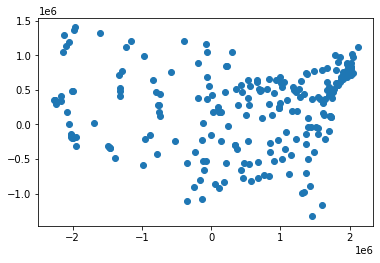

In [31]:
gdf.plot()

Reproject as WGS84

<AxesSubplot:>

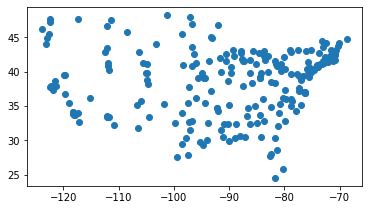

In [32]:
gdf = gdf.to_crs("EPSG:4326")
gdf.plot()

## Export

In [33]:
filename = EXPORT_DIR.joinpath("great-migration-places-geo.json")
filename

PosixPath('/Users/kelud/Code/outliers/src/data/great-migration-places-geo.json')

In [34]:
gdf.to_file(filename, driver="GeoJSON")